# the projection of community based on users and topics

**Introduction**\
Online political communication facilitated by social media platforms has engaged the public in cyberspace with flexible community boundaries and topical agendas. Despite its convenience and openness, the shared space is nevertheless facing problems such as opinion polarization, dis/misinformation spreading, and toxic trolling behaviors that pose threats to a tolerant and civil common ground. For computational social scientists, these challenges ask for an up-to-date understanding of how users navigate in a virtual platform and participate in political conversations. Using a dataset of 49 active political subreddits from 2012 to 2015, this project adopts a network analytics approach to present a case study of how users, topics and communities are interconnected in online political discussions, and how the structure of nested threads (e.g., structural vitality[1]) correlate with the level of conversation toxicity.

**Dataset**\
I have collected a dataset of all submissions and comments from 49 political subreddits from 2012 to 2015 using Pushshift API[2]. Each entry has a corresponding id, timestamp, author, text body and toxicity score (assigned by Perspective API).

**Reference**\
[1] Goel, S., Anderson, A., Hofman, J., & Watts, D. J. (2016). The structural virality of online diffusion. Management Science, 62(1), 180-196.\
[2] Baumgartner, J., Zannettou, S., Keegan, B., Squire, M., & Blackburn, J. (2020, May). The pushshift reddit dataset. In Proceedings of the international AAAI conference on web and social media (Vol. 14, pp. 830-839).


In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import sqlite3
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
from itertools import combinations

import warnings
warnings.filterwarnings('ignore')

from utils import ROOTPATH, build_df_year, generate_index

In [2]:
df2012 = build_df_year(2012)
generate_index()

from utils import USERS, SUBREDDITS, user2index, index2user, subr2index, index2subr

building base dataframe for year 2012...
- fetching submissions for year 2012
- fetching comments for year 2012


## user-level

* link:
    - shared subreddits (too dense, does not make sense intuitively)
    - shared submissions

In [3]:
def plot_user_subr_distribution(dfyear, year):
    user_aggr = dfyear.groupby("author").agg({"subreddit": lambda x: set(list(x))}).reset_index()
    user_aggr["n_subr"] = user_aggr["subreddit"].map(lambda x: len(x))
    sns.histplot(user_aggr["n_subr"], bins=15, color="#FF4500")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("# of subreddits", fontsize=14)
    plt.ylabel("# of users", fontsize=14)
    # plt.show()
    plt.savefig(ROOTPATH + f"output/fig/user_subreddit_distribution_{year}.svg")
    return user_aggr

In [4]:
def plot_user_subm_distribution(dfyear, year):
    user_aggr = dfyear.groupby("author").agg({"submission_id": lambda x: set(list(x))}).reset_index()
    user_aggr["n_subm"] = user_aggr["submission_id"].map(lambda x: len(x))
    sns.histplot(user_aggr["n_subm"], bins=20, color="#FF4500")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("# of submissions", fontsize=14)
    plt.ylabel("# of users", fontsize=14)
    # plt.show()
    plt.savefig(ROOTPATH + f"output/fig/user_submission_distribution_{year}.svg")
    return user_aggr

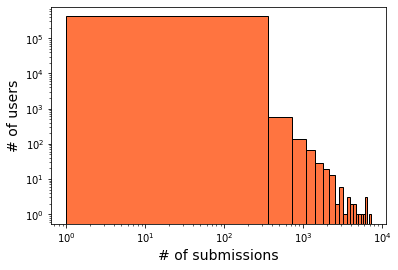

In [5]:
user_aggr2012 = plot_user_subm_distribution(df2012, "2012")

In [6]:
ACTIVEUSERS = user_aggr2012[user_aggr2012["n_subm"]>=10].author.unique()
df2012 = df2012[df2012["author"].isin(ACTIVEUSERS)]

In [7]:
subm_aggr = df2012.groupby("submission_id").agg({"author": lambda x: set(list(x))}).reset_index()
subm_aggr["n_user"] = subm_aggr["author"].map(lambda x: len(x))

In [11]:
subm_aggr[subm_aggr["n_user"]>1]

,submission_id,author,n_user
3,1000ce,"{doctorquien, IrishJoe, Pendit76, willanthony,...",6
4,1000en,"{hollaback_girl, tophat_jones, ufo8314, 100000...",11
7,1000oi,"{Resp_Sup, theodorAdorno, internetUser0001, to...",29
8,1000su,"{GOPWN, samurai77, balorina, cass314, moderp, ...",118
11,1001cf,"{oussan, badsider, xnihil0zer0}",3
...,...,...,...
374627,zzysf,"{Gil_V, yep45, AmericCanuck, feduzzle}",4
374631,zzzk6,"{moving-target, javastripped, MagCynic, ProBot...",42
374633,zzzte,"{MY_NAME_IS_TODD, TomCat1948, matrixfs, palsh7}",4
374634,zzzus,"{FarsideSC, doofy10}",2


In [ ]:
user_edges = {}
subm_aggr = subm_aggr[subm_aggr["n_user"]>1].reset_index().drop(columns=["index"])

for i,row in subm_aggr.iterrows():
#     subm = row["submission_id"]
    users = list(row["author"])
    if i%5000==0: print("progress:", i/len(subm_aggr))
    userpairs = [*combinations(users,2)]
    for i,up in enumerate(userpairs):
        u1 = min(user2index[up[0]],user2index[up[1]])
        u2 = max(user2index[up[0]],user2index[up[1]])
        try:
            user_edges[(u1, u2)] += 1
        except:
            user_edges[(u1, u2)] = 1

progress: 0.0
progress: 0.025490825851775947
progress: 0.05098165170355189
progress: 0.07647247755532784
progress: 0.10196330340710379
progress: 0.12745412925887972
progress: 0.15294495511065567
progress: 0.17843578096243162
progress: 0.20392660681420757
progress: 0.22941743266598352
progress: 0.25490825851775945
progress: 0.2803990843695354
progress: 0.30588991022131135
progress: 0.3313807360730873
progress: 0.35687156192486325
progress: 0.38236238777663917
progress: 0.40785321362841515
progress: 0.43334403948019107
progress: 0.45883486533196705
progress: 0.48432569118374297
progress: 0.5098165170355189
progress: 0.5353073428872949
progress: 0.5607981687390708
progress: 0.5862889945908467
progress: 0.6117798204426227
progress: 0.6372706462943987
progress: 0.6627614721461746
progress: 0.6882522979979505
progress: 0.7137431238497265
progress: 0.7392339497015025
progress: 0.7647247755532783
progress: 0.7902156014050543
progress: 0.8157064272568303


In [26]:
subm_aggr[subm_aggr["n_user"]>1].reset_index().drop(columns=["index"])

,submission_id,author,n_user
0,1000ce,"{DonkeyDickDoak, willanthony, doctorquien, CRY...",6
1,1000en,"{Anjin, 1000000students, NWTboy, dfaraci, Detr...",11
2,1000oi,"{HuMcK, Mythril_Zombie, Inuma, shotglass49, Re...",29
3,1000su,"{nationalistsaturnist, nosferatv, L_Duo, cass3...",118
4,1001cf,"{xnihil0zer0, oussan, badsider}",3
...,...,...,...
196144,zzysf,"{Gil_V, yep45, AmericCanuck, feduzzle}",4
196145,zzzk6,"{CthulhusCallerID, IntrepidSI, this_too_shall_...",42
196146,zzzte,"{palsh7, TomCat1948, matrixfs, MY_NAME_IS_TODD}",4
196147,zzzus,"{doofy10, FarsideSC}",2


In [13]:
u = nx.Graph()
u.add_edges_from([(1,2),(1,3),(1,4),(2,4),(3,5)])

In [15]:
for i, (u1, u2) in enumerate(u.edges()):
    print(i,u1,u2)

0 1 2
1 1 3
2 1 4
3 2 4
4 3 5


In [9]:
MULTICOMMUSERS = user_aggr2012[user_aggr2012["n_subr"]>2].author.unique()
df2012 = df2012[df2012["author"].isin(MULTICOMMUSERS)]

In [10]:
comm_aggr = df2012.groupby("subreddit").agg({"author": lambda x: set(list(x))}).reset_index()
comm_aggr["n_user"] = comm_aggr["author"].map(lambda x: len(x))

In [11]:
user_edges = {}

for i,row in comm_aggr.iterrows():
    subr = row["subreddit"]
    users = list(row["author"])
    print("processing community:", i, subr)
    userpairs = [*combinations(users,2)]
    for i,up in enumerate(userpairs):
        u1 = min(user2index[up[0]],user2index[up[1]])
        u2 = max(user2index[up[0]],user2index[up[1]])
        try:
            user_edges[(u1, u2)] += 1
        except:
            user_edges[(u1, u2)] = 1

processing community: 0 Anarchism
processing community: 1 Anarchy101
processing community: 2 AskALiberal
processing community: 3 Conservative
processing community: 4 DebateCommunism
processing community: 5 DebateaCommunist
processing community: 6 Democrat
processing community: 7 ElizabethWarren
processing community: 8 EnoughLibertarianSpam
processing community: 9 GreenParty
processing community: 10 IWW
processing community: 11 Liberal
processing community: 12 LibertarianLeft
processing community: 13 LibertarianSocialism
processing community: 14 PoliticalHumor
processing community: 15 Republican
processing community: 16 ShitLiberalsSay
processing community: 17 ShitPoliticsSays
processing community: 18 SocialDemocracy
processing community: 19 anarchafeminism
processing community: 20 anarchocommunism
processing community: 21 askaconservative
processing community: 22 chomsky
processing community: 23 circlebroke
processing community: 24 circlebroke2
processing community: 25 communism
proces

In [13]:
userg = nx.Graph()

for p,w in user_edges.items():
    userg.add_edge(p[0], p[1], weight=w)

In [18]:
# export edgelist and nodelist to csv
edgedf = pd.DataFrame()
sources = []
targets = []
weights = []

nodedf = pd.DataFrame()
nodedf["Label"] = MULTICOMMUSERS
nodedf["Id"] = nodedf["Label"].map(lambda x: subr2index[x])

for p,w in user_edges.items():
    sources.append(p[0])
    targets.append(p[1])
    weights.append(w)
edgedf["Source"] = sources
edgedf["Target"] = targets
edgedf["Weight"] = weights

edgedf.to_csv(ROOTPATH + "output/user_edge_2012.csv", index=False)
nodedf.to_csv(ROOTPATH + "output/user_node_2012.csv", index=False)

In [25]:
edgedf[edgedf["Weight"]>2]

# TODO: compute the distribution of jaccard similarity and filter the graph!
# TODO: write that Wikipedia article
# TODO: write the research question of 6014

,Source,Target,Weight
0,116584,127503,3
11,108557,127503,3
14,127503,128207,3
21,127503,131705,3
28,125891,127503,3
...,...,...,...
55860759,72787,135609,3
55860763,1575,135609,3
55860774,414,135609,3
55860835,1575,72787,3


## community graph

In [42]:
comm_aggr = df2012.groupby("subreddit").agg({"author": lambda x: set(list(x))}).reset_index()
comm_aggr["n_user"] = comm_aggr["author"].map(lambda x: len(x))

cedge_df = pd.DataFrame()
sources = []
targets = []
weights = []

for i,row in comm_aggr.iterrows():
    N = len(comm_aggr)  # number of communities
    n1 = row["subreddit"]
    set1 = row["author"]
    if i == N-1:
        break
    for j in range(i+1, N):
        n2 = comm_aggr.iloc[j]["subreddit"]
        set2 = comm_aggr.iloc[j]["author"]
        if len(set1.intersection(set2)) > 0:
            sources.append(n1)
            targets.append(n2)
            weights.append(len(set1.intersection(set2)))
            
cedge_df["Source"] = [subr2index[s] for s in sources]
cedge_df["Target"] = [subr2index[t] for t in targets]
cedge_df["Weight"] = weights
cedge_df.to_csv("subr_edge_2012.csv",index=False)

In [31]:
comm_df = pd.read_csv(ROOTPATH + "indx/left-right-labels.csv")

In [46]:
cnode = pd.DataFrame()
cnode["Label"] = [s.lower() for s in SUBREDDITS]
cnode["Id"] = cnode["Label"].map(lambda x: subr2index[x])
cnode = cnode.merge(comm_df, left_on="Label", right_on="subreddit", 
                    how="left").drop(columns=["subreddit"]).rename(columns={"label":"type"})
cnode.to_csv("subr_node_2012.csv", index=False)

## write node and edge list

In [12]:
edgelist = df2012.reset_index()[["index","author","subreddit"]].groupby(["author","subreddit"]).count()
edgelist = edgelist.reset_index().rename(columns={"author":"Source", "subreddit":"Target", "index":"Weight"})

edgelist[["Source","Target"]].to_csv("edge2012.csv", index=False)

In [4]:
users = pd.DataFrame()
subrs = pd.DataFrame()
users["Label"] = USERS
users["type"] = "user"
subrs["Label"] = SUBREDDITS
subrs["type"] = "subreddit"
nodedf = pd.concat([users, subrs], axis=0)

nodedf.to_csv("node2012.csv", index=False)

## subreddit graph

In [ ]:
# TODO: build tree graphs for a submission
# TODO: calculate structural virality for each submission

## wrap-up

In [ ]:
df2012 = build_df_year(2012)
generate_index()

from utils import USERS, SUBREDDITS, user2index, index2user, subr2index, index2subr

## misc

In [ ]:
# def generate_user_graph(dfyear, year)

comm_aggr = df2012.groupby("subreddit").agg({"author": lambda x: set(list(x))}).reset_index()
comm_aggr["n_user"] = comm_aggr["author"].map(lambda x: len(x))

comm_aggr.to_pickle("comm_aggr2012.pkl")

In [ ]:
import pickle
with open("user2index2012.pkl", 'wb') as handle:
    pickle.dump(user2index, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [40]:
# build user graph
# iterate over nodes: --> too slow
# uedge_df = pd.DataFrame()
# sources = []
# targets = []
# weights = []

# for i,row in user_aggr.iterrows():
#     print(i)
#     N = len(user_aggr)  # number of users
#     n1 = row["author"]
#     set1 = row["subreddit"]
#     if i == N-1:
#         break
#     for j in range(i+1, N):
#         if j%10000 == 0: print("progress", j, "in", range(i+1, N))
#         n2 = user_aggr.iloc[j]["author"]
#         set2 = user_aggr.iloc[j]["subreddit"]
#         if len(set1.intersection(set2)) > 0:
#             sources.append(n1)
#             targets.append(n2)
#             weights.append(len(set1.intersection(set2)))

In [11]:
# create a bipartite graph
# bip = nx.Graph()
# bip.add_nodes_from(USERS, bipartite=0)
# bip.add_nodes_from(SUBREDDITS, bipartite=1)
# for _,row in user_aggr.iterrows():
#     if _ %10000==0: print("progress:", _/len(user_aggr))
#     u = row["author"]
#     subrs = row["subreddit"]
#     bip.add_edges_from([(u,s) for s in list(subrs)])

# user_nodes = {n for n,d in bip.nodes(data=True) if d["bipartite"]==0}

# user_proj = bipartite.projected_graph(bip, user_nodes)  # takes too long to run
# nx.write_gexf(bip, "test.gexf")  # --> this is slow too